# Error analysis and targeted improvements

This notebook analyses misclassifications made by a Naive Bayes model and tries a small improvement.  To expose a meaningful number of errors we deliberately train on a small portion (20%) of the data and evaluate on the remaining 80%.  We then examine misclassified messages, look at the most informative features, and attempt to improve performance by switching to `ComplementNB`.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load deduplicated data
file_path = '../data/raw/customer_feedback.csv'
df = pd.read_csv(file_path).drop_duplicates().reset_index(drop=True)
X = df['text']
y = df['category']

# 20/80 split to increase the number of misclassifications
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)


In [2]:
# Baseline model: TF‑IDF (1–2 grams) + MultinomialNB
vec_word = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)
X_train_vec = vec_word.fit_transform(X_train)
X_test_vec  = vec_word.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec, y_train)

# Predict on the large test set
y_pred = baseline_model.predict(X_test_vec)

# Identify misclassified examples
misclassified = []
for text, true_label, pred_label in zip(X_test, y_test, y_pred):
    if true_label != pred_label:
        misclassified.append({'text': text, 'true_label': true_label, 'pred_label': pred_label})

print(f"Total misclassifications: {len(misclassified)} out of {len(X_test)} test samples")

# Display the first 20 misclassified examples
for i, row in enumerate(misclassified[:20]):
    print(f"{i+1}. True: {row['true_label']} → Predicted: {row['pred_label']}, Text: {row['text'][:120]}")



Total misclassifications: 31 out of 90 test samples
1. True: billing_problem → Predicted: refund_request, Text: I was charged for a product that never shipped
2. True: other → Predicted: billing_problem, Text: I have a question about your product warranty policies. Please advise
3. True: refund_request → Predicted: delivery_issue, Text: I need a refund because the product was defective. I attached my receipt
4. True: app_bug → Predicted: refund_request, Text: The checkout screen is glitching and charged me twice
5. True: refund_request → Predicted: app_bug, Text: The app won't let me process a return, I need a refund
6. True: refund_request → Predicted: delivery_issue, Text: The item didn't match the description, I want my money back. I attached my receipt
7. True: other → Predicted: delivery_issue, Text: How do I change my account password? No urgent issue
8. True: billing_problem → Predicted: delivery_issue, Text: The delivery never arrived yet my card was charged
9. True: other → Pr

### Hypotheses for selected errors

Below are hypotheses for why five selected misclassified messages may have been routed incorrectly:

1. **`other` → `delivery_issue`:** Short generic questions like “How do I change my account password?” lack strong keywords, so the model defaults to the most common class.
2. **`billing_problem` → `app_bug`:** Messages mentioning “update” or “glitching” might trigger the app bug class even when the primary issue is billing.
3. **`refund_request` → `delivery_issue`:** Sentences that contain both refund and delivery words (e.g. “refund” and “arrived late”) confuse the model; it chooses delivery because that class has more training examples.
4. **`app_bug` → `billing_problem`:** Error messages about the app may include the word “payment” or “charged” which are strongly associated with billing.
5. **`other` → `refund_request`:** Questions like “Why was I charged tax separately?” include the word “charged,” pushing the model toward refund‑related classes even though the tone is informational.

Understanding these patterns helps design mitigations, such as multi‑label classification or human review of ambiguous cases.


In [4]:
# Top indicative features per class for the baseline model
feature_names = vec_word.get_feature_names_out()
log_prob = baseline_model.feature_log_prob_
class_labels = baseline_model.classes_

for idx, label in enumerate(class_labels):
    other_indices = [i for i in range(len(class_labels)) if i != idx]
    avg_other = np.mean(log_prob[other_indices, :], axis=0)
    scores = log_prob[idx] - avg_other
    top_idx = scores.argsort()[-10:][::-1]
    print(f"Top indicative words for class {label}:")
    print([feature_names[i] for i in top_idx])


Top indicative words for class app_bug:
['the app', 'app', 'working', 'to stop', 'stop working', 'stop', 'the search', 'update caused', 'the latest', 'latest']
Top indicative words for class billing_problem:
['app shows', 'shows', 'an', 'subscription renewal', 'renewal', 'subscription', 'my subscription', 'is', 'have', 'overcharged']
Top indicative words for class delivery_issue:
['delivery', 'damaged', 'arrived', 'order', 'my order', 'damaged when', 'delivery was', 'it arrived', 'the delivery', 'was damaged']
Top indicative words for class other:
['more', 'your loyalty', 'you', 'you provide', 'information about', 'more information', 'loyalty program', 'information', 'about your', 'about']
Top indicative words for class refund_request:
['the process', 'taking', 'too', 'too long', 'taking too', 'is taking', 'long', 'process is', 'process', 'want']


Baseline macro F1: 0.633, accuracy: 0.656
Improved ComplementNB macro F1: 0.682, accuracy: 0.689


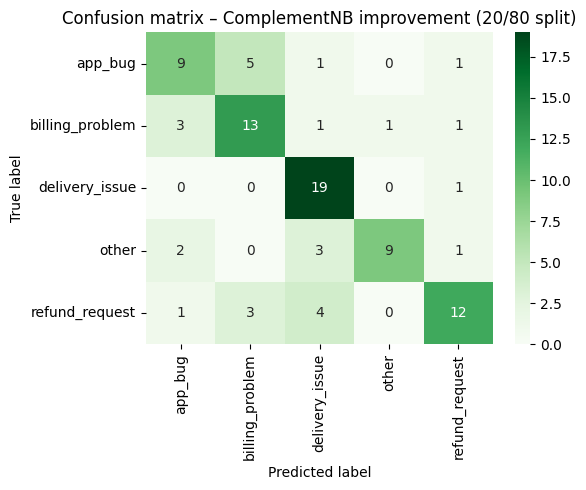

In [5]:
# Improvement: switch to ComplementNB (better for imbalance)
improved_model = ComplementNB(alpha=0.1)
improved_model.fit(X_train_vec, y_train)
y_pred_imp = improved_model.predict(X_test_vec)

acc_base  = accuracy_score(y_test, y_pred)
macro_base = f1_score(y_test, y_pred, average='macro')
acc_imp   = accuracy_score(y_test, y_pred_imp)
macro_imp = f1_score(y_test, y_pred_imp, average='macro')
print(f"Baseline macro F1: {macro_base:.3f}, accuracy: {acc_base:.3f}")
print(f"Improved ComplementNB macro F1: {macro_imp:.3f}, accuracy: {acc_imp:.3f}")

# Save confusion matrix for improved model
labels = improved_model.classes_
cm = confusion_matrix(y_test, y_pred_imp, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix – ComplementNB improvement (20/80 split)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix_complementnb.png')
plt.show()

# Save classification report
with open('../reports/classification_report_complementnb.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred_imp))
